# Анализ способов увеличения выручки

Вместе с отделом маркетинга крупного интернет-магазина был подготовлен список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

# Цели
- приоритизировать гипотезы
- провести А/В тест
- проанализировать результаты

# Описание данных
Данные для первой части

Файл /datasets/hypothesis.csv. 
- 	Hypothesis — краткое описание гипотезы;
-	Reach — охват пользователей по 10-балльной шкале;
-	Impact — влияние на пользователей по 10-балльной шкале;
-	Confidence — уверенность в гипотезе по 10-балльной шкале;
-	Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Файл /datasets/orders.csv. 
-	transactionId — идентификатор заказа;
-	visitorId — идентификатор пользователя, совершившего заказ;
-	date — дата, когда был совершён заказ;
-	revenue — выручка заказа;
-	group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 

-	date — дата;
-	group — группа A/B-теста;
-   visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

try:
    visitors, orders, hypothesis = (
        pd.read_csv('E:/Python/Project 6/visitors.csv'),  
        pd.read_csv('E:/Python/Project 6/orders.csv'),  
        pd.read_csv('E:/Python/Project 6/hypothesis.csv'),  
    )
except:
    visitors, orders, hypothesis = (
        pd.read_csv('/datasets/visitors.csv'),  
        pd.read_csv('/datasets/orders.csv'),  
        pd.read_csv('/datasets/hypothesis.csv'),  
    )

In [2]:
visitors.info()
visitors.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


In [3]:
orders.info()
orders.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [4]:
hypothesis.info()
hypothesis.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10


In [5]:
# Приведем название всех колонок к нижнему регистру и переименуем некоторые колонки
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
hypothesis.columns = hypothesis.columns.str.lower()


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
# ищем пользователей, попавших в обе группы
a= orders.query('group == "A"')['visitor_id']
b= orders.query('group == "B"')['visitor_id']
errors = orders.query('visitor_id in @a and visitor_id in @b')['visitor_id'].unique()
len(errors)
 


58

In [8]:
# удаляем пользователей, попавших в обе группы
orders = orders.query('visitor_id not in @errors')
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


ВЫВОД: 


Таблицы с гипотезами, заказами и визитами отимизированы и готовы к дальнейшей работе. Было обнаружено 58 пользователей, которые попали в обе группы. Для чистоты эксперимента они были удалены.

## 2. Приоритизация гипотез.
###  2.1 Применим фреймворк ICE для приоритизации гипотез. 

In [9]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

hypothesis ['ICE']= ((hypothesis['impact']* hypothesis['confidence'] )/hypothesis ['efforts']).round(1)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Наиболее перспективные гипотезы по ICE:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию 

### 2.2 Применим фреймворк RICE для приоритизации гипотез. 

In [10]:
hypothesis ['RICE']= (hypothesis['reach']*hypothesis['impact']* hypothesis['confidence'] )/hypothesis ['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### 	Сравним приоритизации гипотез при применении RICE и ICE. 

Топ гипотез не зависимо от способа приоритезации: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

В ICE на первом месте следующая гипоза, в то время как в RICE эта гипотеза только на 5 месте:
- Запустить акцию, дающую скидку на товар в день рождения

Обратная ситуация с гипотезой:
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	 

Так произошло, потому что параметр "reach" этих гипотез значительно влияет на их место в рейтинге.

ВЫВОД: По совокупности приоретизаций гипотез наиболее перспективными являются гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию


## 3. A/B-тест
### 3.1 Построим график кумулятивной выручки по группам. 

In [11]:

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]



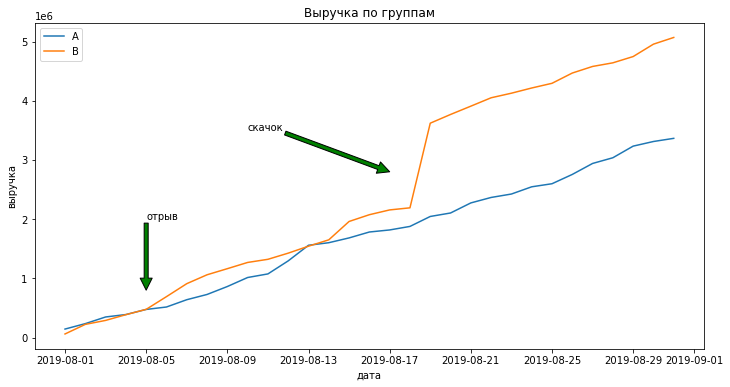

In [12]:
# Строим график выручки группы А
fig, test = plt.subplots()
test.set_title('Выручка по группам')
test.set_xlabel('дата')
test.set_ylabel('выручка')
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(
    cumulativeRevenueB['date'], 
    cumulativeRevenueB['revenue'], 
    label='B'
)
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.legend() 

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:


Выручка группы А растет равномерно на протяжении всего теста. В группе В выручка также растет, но заметен резкий всплеск, возможно на него повлияли выбросы.

### 3.2 Построим график кумулятивного среднего чека по группам.

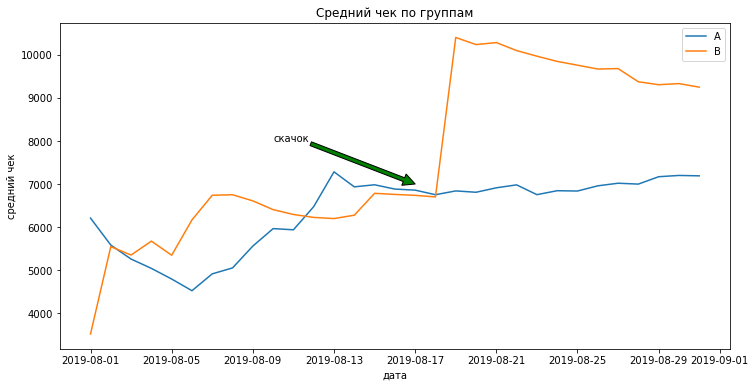

In [13]:
fig, test = plt.subplots()
test.set_title('Средний чек по группам')
test.set_xlabel('дата')
test.set_ylabel('средний чек')
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 7000), xytext=('2019-08-10', 8000),
            arrowprops=dict(facecolor='g'))
plt.legend() 

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Средний чек группы А стабилизируется во второй половине теста. В группе В также в середине теста резкий всплеск среднего чека, что так же говорит о влияние выбросов. Нужно больше денных, чтобы прийти к реальном среднему чеку.

### 3.3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

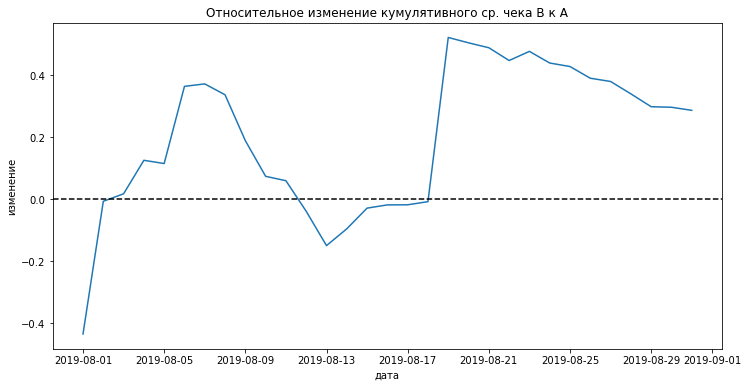

In [14]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


fig, test = plt.subplots()
test.set_title('Относительное изменение кумулятивного ср. чека В к А')
test.set_xlabel('дата')
test.set_ylabel('изменение')
fig.set_figheight(6)
fig.set_figwidth(12)

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

На этом графике также видны резкие всплески и падения, которые говорят о влиянии крупных заказов и выбросов. Пока прослеживается более высокий средний чек в группе В.

### 3.4 Построим график кумулятивной конверсии по группам. 

(18109.0, 18140.0, 0.0, 0.05)

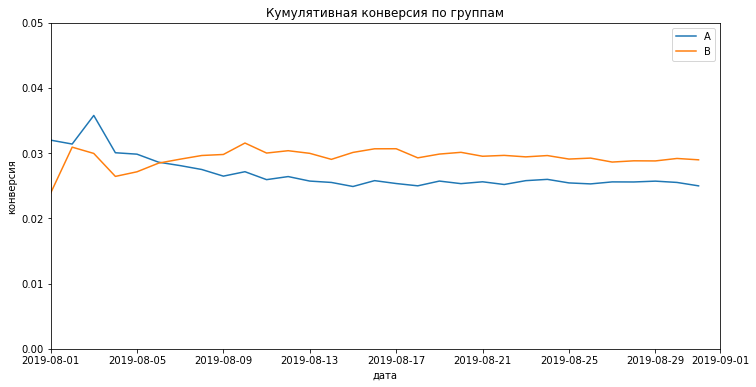

In [15]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig, test = plt.subplots()
test.set_title('Кумулятивная конверсия по группам')
test.set_xlabel('дата')
test.set_ylabel('конверсия')
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05]) 

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

В первой половине теста видны колебания конверсии, во второй половине значения конверсий групп А и В установились на своих значениях. Коневерсия группы В выше, чем А примерно на 15%.

### 3.5 Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

(18109.0, 18140.0, -0.3, 0.3)

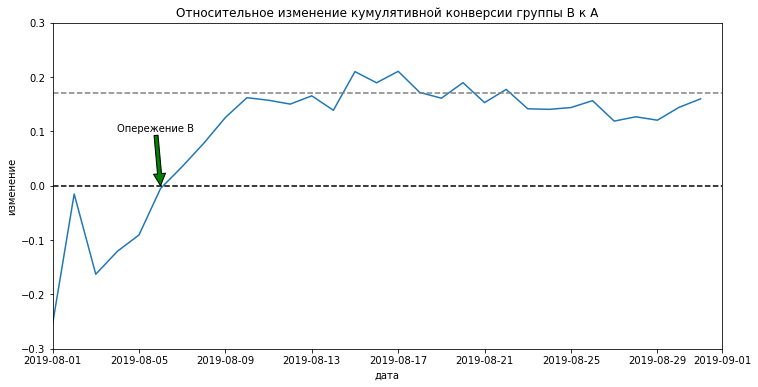

In [16]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig, test = plt.subplots()
test.set_title('Относительное изменение кумулятивной конверсии группы В к А')
test.set_xlabel('дата')
test.set_ylabel('изменение')
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.annotate('Опережение В', xy=('2019-08-06', 0), xytext=('2019-08-04', 0.1),
            arrowprops=dict(facecolor='g'))

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.17, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.3, 0.3]) 

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Вначале теста видны значительные колебания прироста конверсии группы В относительно А, затем В вырвалась вперед и дережтся в лидерах с небольшими колебанеями. Для окончательных выводов сначала нужно проанализировать аномалии.

### 3.6 Построим точечный график количества заказов по пользователям. 

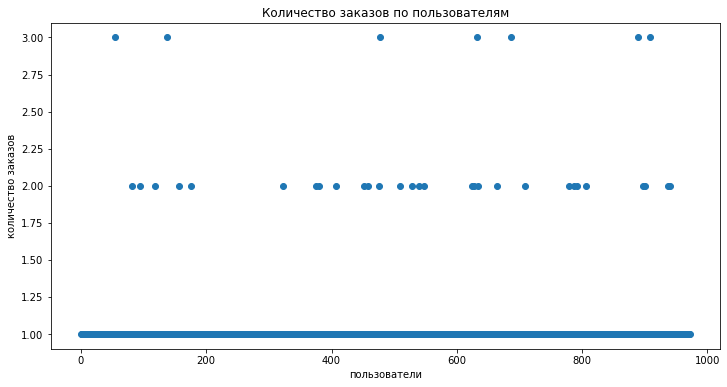

In [17]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['visitor_id', 'transaction_id']

x_values = pd.Series(range(0,len(ordersByUsers)))

fig, test = plt.subplots()
test.set_title('Количество заказов по пользователям')
test.set_xlabel('пользователи')
test.set_ylabel('количество заказов')
fig.set_figheight(6)
fig.set_figwidth(12)
plt.scatter(x_values, ordersByUsers['transaction_id']) 

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Большинство пользователей с 1 заказом. Есть с 2-3 заказами, но конкретная доля не ясна.

### 3.7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [18]:
np.percentile(ordersByUsers['transaction_id'], [95, 99])

array([1., 2.])

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Не более 5% пользователей делали более 1 заказов и не более 1% более 2 заказов. Выберем границу 1 заказа для определения нормальных пользователей.

### 3.8 Построим точечный график стоимостей заказов. 

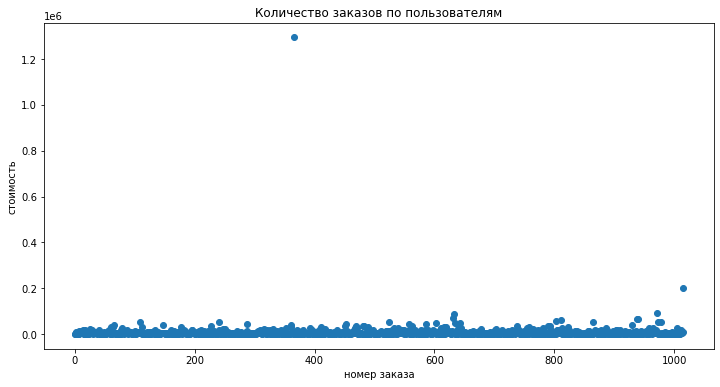

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))
fig, test = plt.subplots()
test.set_title('Количество заказов по пользователям')
test.set_xlabel('номер заказа')
test.set_ylabel('стоимость')
fig.set_figheight(6)
fig.set_figwidth(12)
plt.scatter(x_values, orders['revenue']) 

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

По этому графику очень сложно делать точные выводы, есть заказ с чеком более 1200000, для интернет магазина это слишком крупный заказ и стоит убедиться, что это не ошибка. Можно сказать, что практически все значения лежат в одном диапазоне, и лишь несколько выбиваются. Определим границы их с помощью перентилей.

### 3.9 Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [20]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Не более 5% заказов дороже 27 000 и не более 1% дороже 54 000. Выберем границу 30 000 заказа для определения аномальных пользователей.

### 3.10 Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [21]:
# Начнём с подготовки данных
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


1. Нулевая гипотеза: Статистически значимых различий в конверсии между группами по "сырым данным" нет
2. Обратная гипотеза: Статистически значимые различия в конверсии между группами по "сырым данным" есть

In [22]:
# Посчитаем статистическую значимость различия в конверсии между группами по «сырым» данным.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 


sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1], alternative = 'two-sided'), "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)

('0.006', '0.160')

###### ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Первое число — p-value = 0.006, меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный проигрыш группы А равен 16% — второе число в выводе.

### 3.11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
1. Нулевая гипотеза: Статистически значимых различий в среднем чеке между группами по "сырым данным" нет
2. Обратная гипотеза: Статистически значимые различия в среднем чеке между группами по "сырым данным" есть

In [23]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1], alternative = 'two-sided') 

'0.415'

In [24]:
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.287'

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но, средний чек группы А значительно ниже среднего чека группы В, практичеки на 29%.

### 3.12 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
1. Нулевая гипотеза: Статистически значимых различий в конверсии между группами по "очищенным данным" нет
2. Обратная гипотеза: Статистически значимые различия в конверсии между группами по "очищенным данным" есть

In [25]:
# Выделим аномальных пользователей с количесвом заказов больше 2 и средним чеком выше 30 000
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitor_id, dtype: int64

In [26]:
# Очистим данные от аномальных пользователей и проверим, как изменилась конверсия
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

'{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1], alternative = 'two-sided'), '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

('0.005', '0.187')

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

Статистическая значимость различий конверсии по группам практически не изменилась. Но относительное изменение конверсии по группам стало еще больше: группа А отстает на 18.7%

### 3.13 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
1. Нулевая гипотеза: Статистически значимых различий в среднем чеке между группами по "очищенным данным" нет
2. Обратная гипотеза: Статистически значимые различия в среднем чеке между группами по "очищенным данным" есть

In [27]:
'{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1], 
        alternative = 'two-sided'
    )



'0.370'

In [28]:
"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )

'-0.027'

ВЫВОДЫ И ПРЕДПОЛОЖЕНИЯ:

P-value практически не изменился, а значит статистически значимых различий в среднем чеке так и нет, но и разница между группами стала противоположной, средний чек группы В стал ниже А на 2.7%. Это значит, что аномалии значительно влияют на показатель среднего чека.

#### Подытожим все основные значимые выводы:
- Статистически значимого отличия в среднем чеке по группам нет.
- Конверсия группы В статистически значимо выше, чем А, при сирых и очищенных данных.
- График относительного прироста конверсии показывает, что группа В лучше, т.к. ее показатели зафиксировались выше среднего значения.

Все это дает право остановиться на решении: Остановить тест, зафиксировать победу группы В. Исходя из предоставленных данных, оно принесет больше денег компании.

# Выводы:
- В предоставленных данных было обнаружено 58 пользователей, которые попали в обе группы, данные о которых были удалены.
- По совокупности приоретизаций гипотез наиболее перспективными являются гипотезы. 
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
3. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.
- Крупные заказы очень значительно влияют на выручку и средний чек, что было учтено в анализе.
- Результаты группы В на протяжении всего теста были всегда лучше, чем результаты А, либо не имели статистически значимых отличий. Конверсия В на 18.7% выше конверсии А по "очищенным" данным. Средний чек статистически значимых отличий по группам не имеет.
- Группа В признана победителем теста.